DEP MACHINE LEARNING INTERNSHIP AUGUST 2024 BATCH
CREATED BY: SYED HAMMAD JAVED
TASK NO : 02 EMAIL CLASSIFICATION

IMPORTING REQUIRED LIBRARIES

In [81]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import textblob
from sklearn.utils import shuffle

CLEANING & PREPROCESSING OF DATASET

In [82]:
emails_dataset= pd.read_csv('spam.csv', encoding='latin1')
emails_dataset.head(5)


v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [83]:
emails_dataset.shape

(5572, 5)

In [84]:
emails_dataset.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [85]:
emails_dataset = emails_dataset.rename(columns={'v1':'Prediction', 'v2': 'Email'})

In [86]:
emails_dataset= emails_dataset.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'])

In [87]:
emails_dataset.columns

Index(['Prediction', 'Email'], dtype='object')

LABEL ENCODING PREDICTION COLUMN FOR CLASSIFICATION PURPOSE

In [88]:
encoder = LabelEncoder()
emails_dataset['Prediction']= encoder.fit_transform(emails_dataset['Prediction'])
emails_dataset.head(5)

Prediction                                              Email
0           0  Go until jurong point, crazy.. Available only ...
1           0                      Ok lar... Joking wif u oni...
2           1  Free entry in 2 a wkly comp to win FA Cup fina...
3           0  U dun say so early hor... U c already then say...
4           0  Nah I don't think he goes to usf, he lives aro...

In [89]:
missing_values= emails_dataset.isnull().sum()
print(missing_values)

Prediction    0
Email         0
dtype: int64


In [90]:
duplicate_values = emails_dataset.duplicated().sum()
print(f'duplicate values are:',duplicate_values)

duplicate values are: 403


In [91]:
emails_dataset = emails_dataset.drop_duplicates(keep='first')
emails_dataset.shape

(5169, 2)

In [92]:
emails_dataset.head()

Prediction                                              Email
0           0  Go until jurong point, crazy.. Available only ...
1           0                      Ok lar... Joking wif u oni...
2           1  Free entry in 2 a wkly comp to win FA Cup fina...
3           0  U dun say so early hor... U c already then say...
4           0  Nah I don't think he goes to usf, he lives aro...

Exploratory data analysis

In [93]:
emails_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Prediction  5169 non-null   int32 
 1   Email       5169 non-null   object
dtypes: int32(1), object(1)
memory usage: 101.0+ KB


In [94]:
emails_dataset.describe()

Prediction
count  5169.000000
mean      0.126330
std       0.332253
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [95]:
class_distribution = emails_dataset['Prediction'].value_counts()
print(class_distribution)

Prediction
0    4516
1     653
Name: count, dtype: int64


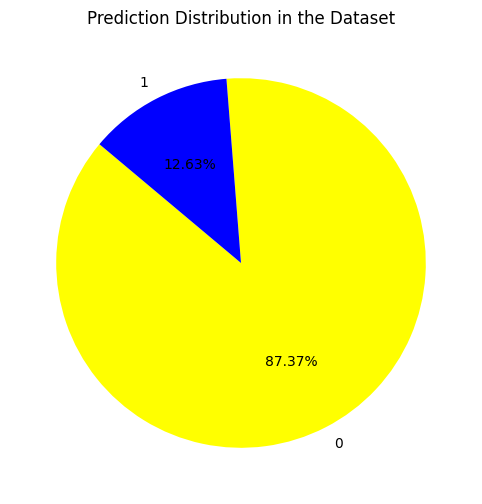

In [96]:
class_counts = emails_dataset['Prediction'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.2f%%', colors=['yellow','blue'], startangle=140)
plt.title('Prediction Distribution in the Dataset')
plt.show()

DISRIBUTION OF SPAM AND NOT NO SPAM EMAILS WHICH IS NOT UNIFORMELY DISTRIBUTED

DOWNSAMPLING THE DATASET FOR EVEN DISTRIBUTION

In [97]:
df_majority = emails_dataset[emails_dataset['Prediction'] == 0]
df_minority = emails_dataset[emails_dataset['Prediction'] == 1]

In [98]:
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

In [99]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [100]:
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [101]:
print(df_downsampled['Prediction'].value_counts())
df_downsampled.head()

Prediction
1    653
0    653
Name: count, dtype: int64


Prediction                                              Email
0           1  Natalja (25/F) is inviting you to be her frien...
1           0  Can't. I feel nauseous. I'm so pissed. I didn'...
2           1  HOT LIVE FANTASIES call now 08707509020 Just 2...
3           1  CLAIRE here am havin borin time & am now alone...
4           1  Want explicit SEX in 30 secs? Ring 02073162414...

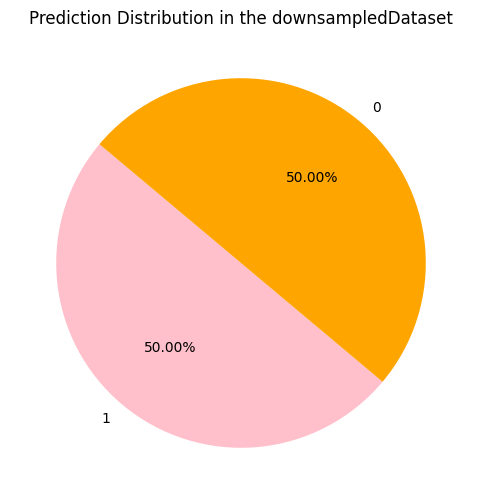

In [102]:
class_counts = df_downsampled['Prediction'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.2f%%', colors=['pink','orange'], startangle=140)
plt.title('Prediction Distribution in the downsampledDataset')
plt.show()

TEXT PREPROCESSING

In [103]:
stopwords = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [112]:
def preprocess_text(text):
 
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

In [116]:
df_downsampled['Preprocessed_Email'] = df_downsampled['Email'].apply(preprocess_text)
df_downsampled.head()

Prediction                                              Email  \
0           1  Natalja (25/F) is inviting you to be her frien...   
1           0  Can't. I feel nauseous. I'm so pissed. I didn'...   
2           1  HOT LIVE FANTASIES call now 08707509020 Just 2...   
3           1  CLAIRE here am havin borin time & am now alone...   
4           1  Want explicit SEX in 30 secs? Ring 02073162414...   

                                  Preprocessed_Email  
0  natalja 25f is inviting you to be her friend r...  
1  cant i feel nauseous im so pissed i didnt eat ...  
2  hot live fantasies call now 08707509020 just 2...  
3  claire here am havin borin time  am now alone ...  
4  want explicit sex in 30 secs ring 02073162414 ...

FEATURE SELECTION

In [118]:
X = df_downsampled['Preprocessed_Email']
y = df_downsampled['Prediction']

In [124]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_downsampled['Preprocessed_Email'])
y = df_downsampled['Prediction']

SPLITTING DATA FOR TRAIN & TEST

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

MODEL TRAINING & EVALUATION

In [127]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [128]:
nb_predictions = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))


Naive Bayes Accuracy: 0.9413265306122449
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       194
           1       0.97      0.91      0.94       198

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



In [129]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [130]:
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

SVM Accuracy: 0.9362244897959183
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       194
           1       0.99      0.88      0.93       198

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392

